In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

### Variable info
1. ID: unique identifier
2. N_Days: number of days between registration and the earlier of death, transplantation, or study analysis time in July 1986
3. Status: status of the patient C (censored), CL (censored due to liver tx), or D (death)
4. Drug: type of drug D-penicillamine or placebo
5. Age: age in [days]
6. Sex: M (male) or F (female)
7. Ascites: presence of ascites N (No) or Y (Yes)
8. Hepatomegaly: presence of hepatomegaly N (No) or Y (Yes)
9. Spiders: presence of spiders N (No) or Y (Yes)
10. Edema: presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
11. Bilirubin: serum bilirubin in [mg/dl]
12. Cholesterol: serum cholesterol in [mg/dl]
13. Albumin: albumin in [gm/dl]
14. Copper: urine copper in [ug/day]
15. Alk_Phos: alkaline phosphatase in [U/liter]
16. SGOT: SGOT in [U/ml]
17. Triglycerides: triglicerides in [mg/dl]
18. Platelets: platelets per cubic [ml/1000]
19. Prothrombin: prothrombin time in seconds [s]
20. Stage: histologic stage of disease (1, 2, 3, or 4)

Class Labels

Status: status of the patient 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation)

In [2]:
df = pd.read_csv('cirrhosis.csv') #Read the data into a pandas dataframe

## Pre-processing and label encoding
Steps taken:


-Observations with na values are dropped 
<br>
-'event_observed' variable is created for later KM/CoxPH fitting based on value in 'Status' variable: 1 for value of D, 0 for C or CL
<br>
-'Edema' variable is label encoded: Y=2, S=1, N=0
<br>
-'Sex','Ascites','Hepatomegaly','Spiders','Drug' are all label encoded as 1 for value of Female, Y, or if the subject took D-penicillamine respectively, 0 else
<br>
-Extra variables that were created by pd.get_dummies() are then dropped, as well as 'Edema' 'ID 'Status' as the information was encoded numerically

In [3]:
df = df.dropna()
df['event_observed'] = df['Status'].apply(lambda x: 1 if x == 'D' else 0)
df["Edema"] = df["Edema"].astype('category')
df['Edema_cat'] = df['Edema'].cat.codes #Y=2 S=1 N=0
df = pd.get_dummies(df, columns=['Sex','Ascites','Hepatomegaly','Spiders','Drug'])
df=df.drop(labels=['Edema','ID','Status','Sex_M','Ascites_N','Hepatomegaly_N','Spiders_N','Drug_Placebo'], axis=1)
df.head()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,event_observed,Edema_cat,Sex_F,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Drug_D-penicillamine
0,400,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0,1,2,True,True,True,True,True
1,4500,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0,0,0,True,False,True,True,True
2,1012,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0,1,1,False,False,False,False,True
3,1925,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0,1,1,True,False,True,True,True
4,1504,13918,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0,0,0,True,False,True,True,False


## Descriptive Stats and Histograms
Ryan has more detailed information located in the Overleaf doc

In [4]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,event_observed,Edema_cat
count,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000,276.000000
mean,1979.166667,18189.326087,3.333696,371.260870,3.516812,100.768116,1996.611594,124.119239,124.978261,261.771739,10.735507,3.039855,0.402174,0.213768
std,1112.380295,3843.555619,4.601074,234.788363,0.404789,88.268746,2115.477894,56.719952,65.280761,93.128857,1.008315,0.853999,0.491227,0.540665
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,28.380000,33.000000,62.000000,9.000000,1.000000,0.000000,0.000000
25%,1185.750000,15162.500000,0.800000,249.500000,3.310000,42.750000,922.500000,82.457500,85.000000,200.000000,10.000000,2.000000,0.000000,0.000000
50%,1788.000000,18156.500000,1.400000,310.000000,3.545000,74.000000,1277.500000,116.625000,108.000000,257.000000,10.600000,3.000000,0.000000,0.000000
75%,2689.750000,20667.500000,3.525000,401.000000,3.772500,129.250000,2068.250000,153.450000,151.250000,318.250000,11.200000,4.000000,1.000000,0.000000
max,4556.000000,28650.000000,28.000000,1775.000000,4.400000,588.000000,13862.400000,457.250000,598.000000,563.000000,17.100000,4.000000,1.000000,2.000000


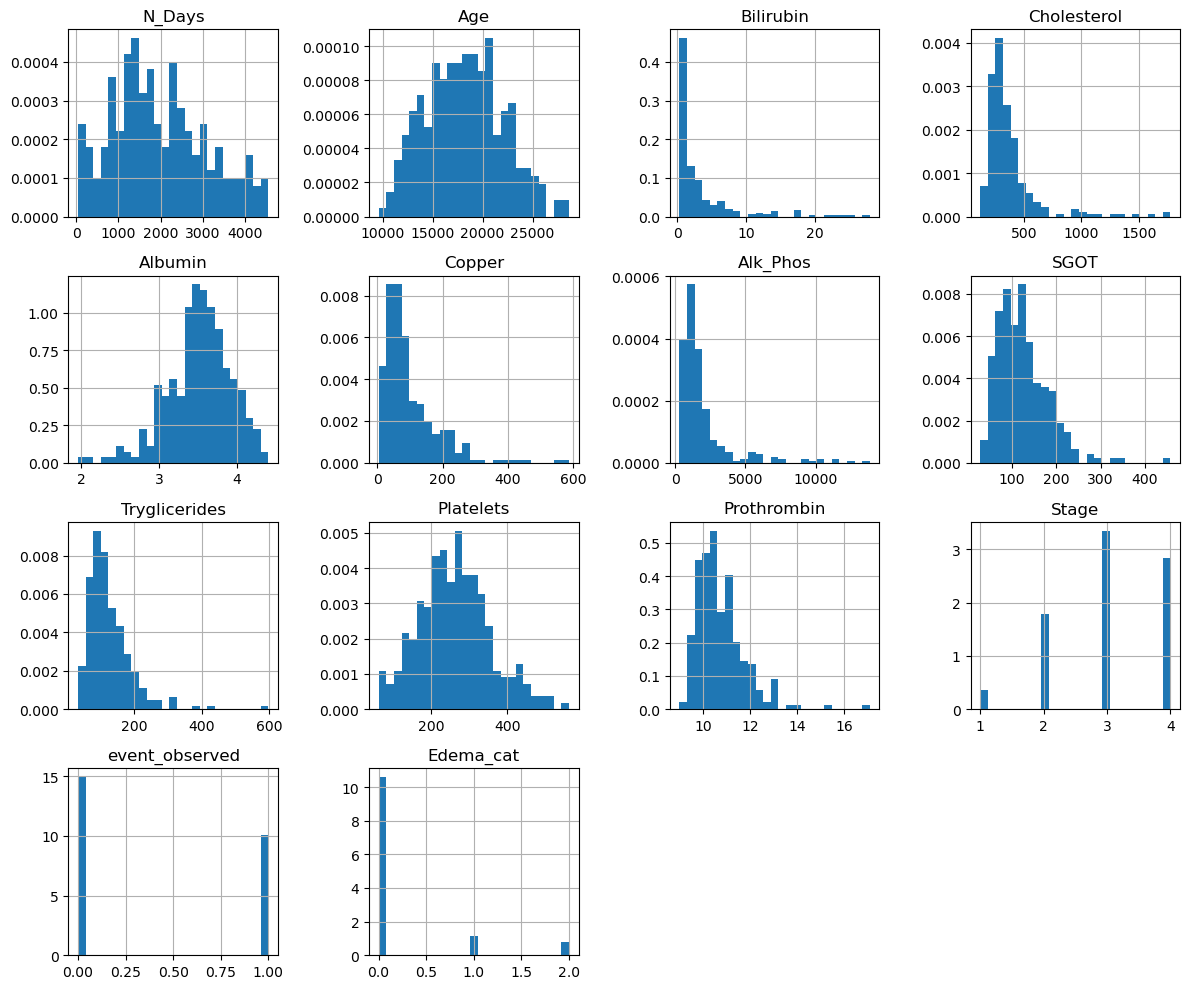

In [5]:
df.hist(density=True, bins=25, figsize=(12, 10), layout=(4, 4))
plt.tight_layout() 
plt.show()

## Correlation matrix checked for collinearity

In [6]:
df.corr()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,event_observed,Edema_cat,Sex_F,Ascites_Y,Hepatomegaly_Y,Spiders_Y,Drug_D-penicillamine
N_Days,1.000000,-0.143223,-0.430252,-0.136734,0.401878,-0.361386,0.104443,-0.191062,-0.163853,0.159121,-0.128406,-0.363880,-0.347634,-0.347114,0.029385,-0.329450,-0.261022,-0.260605,-0.019330
Age,-0.143223,1.000000,0.078177,-0.156638,-0.239676,0.082631,-0.019798,-0.120868,0.024710,-0.149650,0.244774,0.178980,0.277402,0.254105,-0.240648,0.250940,0.080850,-0.004182,0.128076
Bilirubin,-0.430252,0.078177,1.000000,0.394966,-0.312043,0.460527,0.138787,0.424987,0.439691,-0.074395,0.331176,0.247861,0.419211,0.414284,0.027474,0.414603,0.288092,0.261701,-0.080922
Cholesterol,-0.136734,-0.156638,0.394966,1.000000,-0.067299,0.124413,0.152281,0.356971,0.273896,0.192548,-0.033374,0.004573,0.166694,-0.109524,0.008414,-0.057578,0.140896,0.061817,-0.021723
Albumin,0.401878,-0.239676,-0.312043,-0.067299,1.000000,-0.240408,-0.111497,-0.198210,-0.109673,0.198600,-0.199584,-0.310473,-0.276985,-0.391656,-0.079899,-0.403384,-0.271408,-0.225611,-0.053743
Copper,-0.361386,0.082631,0.460527,0.124413,-0.240408,1.000000,0.190912,0.301858,0.284579,-0.083976,0.213770,0.280346,0.368395,0.282815,-0.251731,0.247268,0.224367,0.267521,0.028832
Alk_Phos,0.104443,-0.019798,0.138787,0.152281,-0.111497,0.190912,1.000000,0.145242,0.182566,0.147250,0.087784,0.016821,0.285572,0.060116,-0.019439,0.042037,0.132990,0.035218,0.009397
SGOT,-0.191062,-0.120868,0.424987,0.356971,-0.198210,0.301858,0.145242,1.000000,0.134957,-0.058951,0.069940,0.142341,0.252050,0.140642,-0.008538,0.080520,0.136204,0.091350,-0.040706
Tryglicerides,-0.163853,0.024710,0.439691,0.273896,-0.109673,0.284579,0.182566,0.134957,1.000000,0.101285,0.025087,0.126033,0.212212,0.087190,-0.051218,0.225414,0.162103,0.102546,-0.017799
Platelets,0.159121,-0.149650,-0.074395,0.192548,0.198600,-0.083976,0.147250,-0.058951,0.101285,1.000000,-0.192859,-0.221546,-0.108156,-0.241685,0.095021,-0.211158,-0.179722,-0.157704,-0.039366


## KM and CPH Models
The Kaplan-Meier curve is fit to the data by Drug strata
<br>

Documentation on the Lifelines module used for KM: (https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html#best-practices-for-presenting-kaplan-meier-plots)
<br>
And for CPH: (https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#cox-s-proportional-hazard-model)
<br>
Take note of the p values for each parameter

In [7]:
# We create a variable to later separate observations where D-penicillamine was taken
strata_var = df['Drug_D-penicillamine'] == 1 

Text(0.5, 1.0, 'Survival functions for Placebo vs D-penicillamine groups')

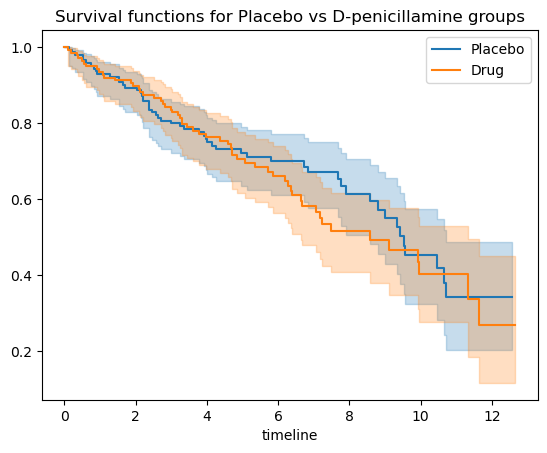

In [8]:
ax = plt.subplot(111)

# Create the Kaplan-Meier fiftter object
kmf = KaplanMeierFitter()
# Fit the stratified data to the kmf object
kmf.fit(durations=df[~strata_var]['N_Days']/360, event_observed=df[~strata_var]['event_observed'],label='Placebo')
# Plot curve 1 'Placebo'
kmf.plot_survival_function(ax=ax)

kmf.fit(durations=df[strata_var]['N_Days']/360, event_observed=df[strata_var]['event_observed'],label='Drug')
# Plot curve 2 'Drug'
kmf.plot_survival_function(ax=ax)
plt.title('Survival functions for Placebo vs D-penicillamine groups')

In [9]:
# Create Cox Proportional Hazards model
cph = CoxPHFitter()
# Fit CPH to data (this is not by strata)
cph.fit(df, duration_col='N_Days', event_col='event_observed')

cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 276 total observations, 165 right-censored observations>
             duration col = 'N_Days'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 276
number of events observed = 111
   partial log-likelihood = -466.33
         time fit was run = 2025-04-18 20:29:34 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Age                   0.00      1.00      0.00            0.00            0.00                1.00                1.00
Bilirubin             0.08      1.08      0.03            0.03            0.13                1.03                1.14
Cholesterol           0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Albumin              -0.74      0.48      0.31           -1.34           -0.14                0.26                0.87
Copper                0.00      1.00      0.00            0.00            0.00                1.00                1.00
Alk_Phos              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
SGOT                  0.00      1.00      0.00            0.00            0.01                1.00                1.01
Tryglicerides        -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Platelets             0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Prothrombin           0.23      1.26      0.11            0.02            0.44                1.02                1.55
Stage                 0.45      1.58      0.18            0.11            0.80                1.12                2.22
Edema_cat             0.51      1.66      0.20            0.12            0.89                1.13                2.44
Sex_F                -0.37      0.69      0.31           -0.98            0.24                0.38                1.28
Ascites_Y             0.09      1.09      0.39           -0.67            0.85                0.51                2.33
Hepatomegaly_Y        0.03      1.03      0.25           -0.47            0.52                0.63                1.68
Spiders_Y             0.10      1.11      0.24           -0.38            0.58                0.69                1.78
Drug_D-penicillamine  0.12      1.13      0.21           -0.30            0.55                0.74                1.72

                      cmp to     z      p  -log2(p)
covariate                                          
Age                     0.00  2.48   0.01      6.26
Bilirubin               0.00  3.14 <0.005      9.20
Cholesterol             0.00  1.11   0.27      1.90
Albumin                 0.00 -2.41   0.02      5.96
Copper                  0.00  2.13   0.03      4.91
Alk_Phos                0.00  0.03   0.98      0.03
SGOT                    0.00  2.08   0.04      4.73
Tryglicerides           0.00 -0.73   0.46      1.11
Platelets               0.00  0.76   0.45      1.16
Prothrombin             0.00  2.19   0.03      5.13
Stage                   0.00  2.59   0.01      6.71
Edema_cat               0.00  2.57   0.01      6.60
Sex_F                   0.00 -1.17   0.24      2.06
Ascites_Y               0.00  0.23   0.82      0.29
Hepatomegaly_Y          0.00  0.10   0.92      0.12
Spiders_Y               0.00  0.42   0.68      0.56
Drug_D-penicillamine    0.00  0.58   0.56      0.83
---
Concordance = 0.85
Partial AIC = 966.66
log-likelihood ratio test = 167.72 on 17 df
-log2(p) of ll-ratio test = 86.70